In [229]:
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import warnings
import chainladder as cl # Sparse=0.14.0 ; incremental.py np.NINF -> -np.inf
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [230]:
def claims_formatter(doc:pd.DataFrame):
    doc_copy = doc.copy()
    #Acomodo indice
    doc_copy.index = doc_copy.AUTOMOTORES
    formatted_doc = doc_copy.iloc[:,4:].stack(level = [0,1,2,3]).reset_index([1,2,3,4]).drop_duplicates()
    formatted_doc.reset_index(inplace = True)
    formatted_doc[['Base Origen', 'Ramo', 'Codigo 1', 'Codigo 2']] = pd.DataFrame(formatted_doc[('index','')].to_list(), index = formatted_doc.index)

    #Acomodo columnas
    formatted_doc.columns = ['indice','Tipo', 'Periodo', 'Desarrollo 1', 'Año Valuacion', 'Pendientes', 'Pagados', 'Incurridos', 'Cantidad', 'Base Origen', 'Ramo', 'Codigo 1', 'Codigo 2']
    formatted_doc['Año Ocurrencia'] = pd.to_datetime(formatted_doc['Periodo'][0][0:5]) + pd.DateOffset(months = 6)
    formatted_doc['Año Valuacion'] = pd.to_datetime(formatted_doc['Año Valuacion'])
    #formatted_doc['Desarrollo'] = formatted_doc['Año Valuacion'] - formatted_doc['Año Ocurrencia']
    formatted_doc.drop(['indice','Tipo', 'Periodo', 'Desarrollo 1'], axis = 1, inplace = True)

    return formatted_doc

def check_chainladdes_assumptions( triangle:cl.Triangle, columns:list, ramos:list=None):
    if ramos == None:
        for column in columns:
            if triangle[column].sum().valuation_correlation(p_critical=0.1, total=True).z_critical.values == True:
                print(f'Triangulo {column}: Años de valuación correlacionados')
            elif triangle[column].sum().development_correlation(p_critical=0.1).t_critical.values == False:
                print(f'Triangulo {column}: Años de desarrollo no correlacionados')
        return 0
    else:
        for ramo in ramos:
            for column in columns:
                if triangle.loc[triangle['Ramo']==ramo, column].sum().valuation_correlation(p_critical=0.1, total=True).z_critical.values == True:
                    print(f'Triangulo {column}: Años de valuación correlacionados')
                elif triangle.loc[triangle['Ramo']==ramo, column].sum().development_correlation(p_critical=0.1).t_critical.values == False:
                    print(f'Triangulo {column}: Años de desarrollo no correlacionados')
            return 0
            

In [231]:
sto_input = pd.read_excel('..\\sample\\ssn_20192020_desarrollo_siniestros_automotores.xlsx', sheet_name = None, header=[0,1,2,3,4,5])
facpce_input = pd.read_excel('..\\sample\\Indice-FACPCE-Res.-JG-539-18-_2025-07-1.xlsx', skiprows = 2, skipfooter=4)

#Tratamiendo desarrollo de stos
#sto_input = dict(itertools.islice(sto_input.items(), 3, len(sto_input)))
sto_input_formateado = [claims_formatter(sto_input[k]) for k in sto_input.keys() if k[0] == '2']
db_stos = pd.concat(sto_input_formateado)

#Tratamiento indice facpce
db_facpce = facpce_input.set_index('MES')
factores_facpce = db_facpce.loc[max(db_stos['Año Valuacion']) - pd.DateOffset(days = 29)] / db_facpce.loc[db_stos['Año Valuacion'] - pd.DateOffset(months = 5, days = 29)] # Asumo que esta todo valuado a mitad de periodo.
db_stos['Factor FACPSE'] = factores_facpce.set_index(db_stos.index)

In [232]:
#Armo el dataframe para el triángulo que quiero analizar 
idx = (db_stos['Base Origen'] == '[HG]')  &  (db_stos['Ramo'] == 'RC')
db_triangle = db_stos.loc[idx, ['Año Ocurrencia', 'Año Valuacion', 'Pendientes','Pagados' , 'Incurridos', 'Factor FACPSE', 'Cantidad']]
db_triangle['Año Valuacion'] = db_triangle['Año Valuacion'] + pd.DateOffset(months = -6)
db_triangle['Año Ocurrencia'] = db_triangle['Año Ocurrencia'] + pd.DateOffset(months = -6)

#Chequeo supuestos para Cl y aplico el factor FACPCE
triang_stos = cl.Triangle(db_triangle, origin = 'Año Ocurrencia', development= 'Año Valuacion', columns = ['Pagados', 'Pendientes', 'Incurridos', 'Cantidad'], cumulative = True)
triang_facpce = cl.Triangle(db_triangle, origin = 'Año Ocurrencia', development= 'Año Valuacion', columns = 'Factor FACPSE', cumulative = True)
triang_stos_act = triang_stos.cum_to_incr() * triang_facpce
check_chainladdes_assumptions(triang_stos_act, ['Pagados', 'Pendientes', 'Incurridos'], ramos = None)

0

In [233]:
triang_stos['Cantidad']

,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240
2000,"501,699","521,463","522,781","523,351","523,543","523,755","523,784","524,924","526,203","526,263","526,372","526,402","526,448","526,485","526,511","526,524","526,533","526,545","526,552","526,557"
2001,"465,120","484,804","486,570","486,857","487,132","487,189","488,714","489,908","490,009","490,067","490,117","490,225","490,270","490,301","490,325","490,350","490,377","490,393","490,413",
2002,"448,063","467,481","469,153","469,583","469,644","471,677","472,791","472,894","472,957","472,984","473,017","473,063","473,090","473,102","473,110","473,123","473,133","473,134",,
2003,"514,255","535,799","537,181","537,483","540,865","541,908","542,071","542,136","542,174","542,200","542,317","542,354","542,373","542,390","542,415","542,425","542,426",,,
2004,"608,657","634,158","635,451","643,538","644,995","645,307","645,427","645,495","645,530","645,683","645,733","645,761","645,773","645,798","645,806","645,811",,,,
2005,"677,285","707,709","745,158","747,644","748,064","748,244","748,352","748,399","748,598","748,668","748,719","748,745","748,782","748,793","748,803",,,,,
2006,"766,312","844,661","877,513","878,493","878,846","879,035","879,109","879,474","879,558","879,633","879,679","879,711","879,735","879,748",,,,,,
2007,"956,302","998,929","1,002,515","1,003,556","1,003,918","1,004,055","1,004,641","1,004,782","1,004,856","1,004,895","1,004,932","1,004,966","1,004,985",,,,,,,
2008,"1,002,116","1,045,839","1,051,719","1,052,658","1,052,926","1,053,703","1,053,920","1,054,041","1,054,103","1,054,132","1,054,162","1,054,188",,,,,,,,
2009,"1,056,217","1,100,129","1,103,256","1,104,024","1,105,123","1,105,395","1,105,595","1,105,698","1,105,746","1,105,774","1,105,791",,,,,,,,,


In [234]:
triang_stos['Pagados'].incr_to_cum()

,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240
2000,"172,984,640","329,612,364","390,332,924","451,909,761","507,237,511","553,850,246","587,170,407","627,690,935","669,926,966","700,023,188","732,192,956","752,107,032","769,189,696","806,960,546","832,123,238","949,962,638","976,361,510","1,013,622,757","1,036,297,699","1,079,567,107"
2001,"184,052,863","358,918,867","435,764,567","487,215,030","534,106,179","576,238,013","606,381,151","648,177,912","684,299,436","718,049,220","754,777,550","789,542,899","818,479,108","868,703,773","890,713,846","912,487,162","941,245,005","962,545,316","985,690,183",
2002,"220,862,368","430,003,452","499,629,650","551,995,859","594,794,582","635,355,877","678,707,585","709,417,959","752,911,599","781,714,406","807,776,821","850,419,880","876,174,847","902,081,270","927,534,046","980,233,126","1,035,201,123","1,120,870,919",,
2003,"265,221,772","528,816,885","631,072,274","700,244,619","748,363,322","801,919,402","857,873,769","912,257,108","961,393,241","1,010,999,442","1,068,025,972","1,131,782,609","1,185,153,427","1,243,209,205","1,328,065,383","1,387,736,210","1,450,988,743",,,
2004,"368,876,819","734,812,738","863,285,611","940,786,706","1,014,687,244","1,090,722,040","1,166,480,816","1,229,251,648","1,287,244,667","1,346,260,447","1,428,558,245","1,506,981,901","1,590,572,114","1,675,546,769","1,786,376,388","1,865,999,498",,,,
2005,"486,596,603","968,445,684","1,120,613,914","1,232,414,708","1,339,467,794","1,446,503,667","1,545,006,516","1,632,508,331","1,734,021,101","1,843,740,547","1,948,967,001","2,096,375,663","2,270,224,260","2,414,725,560","2,531,913,532",,,,,
2006,"622,975,541","1,219,180,219","1,440,447,577","1,590,209,192","1,749,807,183","1,918,360,658","2,060,041,821","2,201,126,136","2,392,576,243","2,579,300,525","2,769,786,435","2,951,697,142","3,174,734,733","3,365,160,200",,,,,,
2007,"809,240,549","1,587,797,265","1,873,643,702","2,092,718,603","2,284,250,200","2,472,101,073","2,675,638,530","2,898,408,106","3,220,762,986","3,512,163,025","3,849,457,973","4,187,817,210","4,455,794,593",,,,,,,
2008,"998,619,688","1,940,586,241","2,271,848,511","2,527,516,276","2,787,157,187","3,015,383,658","3,304,241,541","3,634,158,791","4,038,797,895","4,477,777,696","4,912,825,383","5,238,861,338",,,,,,,,
2009,"1,179,505,100","2,227,711,905","2,607,182,192","2,908,011,796","3,172,654,469","3,498,629,946","3,862,757,232","4,370,926,052","4,873,708,684","5,382,936,110","5,876,516,294",,,,,,,,,


In [235]:
triang_stos_act['Pagados'].incr_to_cum()

,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240
2000,"6,983,616,659","13,263,581,283","14,446,688,469","15,632,425,608","16,626,318,462","17,365,843,293","17,864,055,846","18,390,626,905","18,899,410,396","19,223,557,621","19,526,762,059","19,693,569,103","19,819,981,374","20,054,399,587","20,181,924,495","20,650,402,303","20,734,072,823","20,828,546,939","20,867,050,887","20,915,119,135"
2001,"7,379,571,372","10,786,740,647","12,266,498,380","13,190,740,694","13,934,682,644","14,564,649,830","14,956,364,964","15,459,856,927","15,848,898,834","16,166,995,141","16,474,644,084","16,731,908,789","16,911,496,338","17,166,035,707","17,253,538,112","17,322,548,055","17,395,462,198","17,431,631,906","17,457,343,680",
2002,"4,303,383,495","8,330,650,298","9,581,396,639","10,412,202,040","11,052,140,739","11,579,241,575","12,101,464,731","12,432,226,599","12,842,160,067","13,083,422,135","13,276,284,854","13,540,941,587","13,671,468,156","13,774,460,736","13,855,132,633","13,988,748,639","14,082,088,894","14,177,259,991",,
2003,"5,107,168,885","9,842,320,776","11,464,632,760","12,498,917,384","13,124,228,000","13,769,375,019","14,372,023,837","14,884,594,205","15,296,175,104","15,663,262,596","16,017,187,843","16,340,307,451","16,552,486,432","16,736,492,672","16,951,641,471","17,052,967,522","17,123,235,146",,,
2004,"6,626,404,193","12,432,085,776","14,353,048,797","15,360,188,528","16,250,408,859","17,069,331,186","17,783,367,954","18,309,157,713","18,738,307,926","19,104,579,112","19,521,665,609","19,833,443,690","20,098,380,641","20,313,829,830","20,502,027,788","20,590,481,586",,,,
2005,"7,719,999,021","14,924,743,824","16,902,195,496","18,248,969,735","19,401,970,285","20,410,797,941","21,235,891,187","21,883,407,450","22,513,428,817","23,069,488,644","23,487,822,904","23,955,030,727","24,395,815,562","24,641,190,850","24,771,375,681",,,,,
2006,"9,314,907,864","17,062,687,672","19,728,117,554","21,341,104,445","22,845,337,219","24,257,198,238","25,305,643,428","26,181,258,714","27,151,530,778","27,893,864,684","28,497,604,692","28,958,830,625","29,337,567,099","29,549,111,909",,,,,,
2007,"10,516,216,689","19,894,863,214","22,973,532,974","25,038,343,715","26,642,677,274","28,032,779,811","29,295,999,666","30,424,999,279","31,706,540,995","32,630,125,644","33,485,320,919","34,059,883,188","34,357,580,894",,,,,,,
2008,"12,029,568,137","22,174,889,429","25,297,081,370","27,438,641,215","29,359,992,355","30,776,440,283","32,240,376,446","33,551,982,831","34,834,475,675","35,947,488,050","36,686,235,390","37,048,430,718",,,,,,,,
2009,"12,703,697,559","22,583,189,260","25,761,760,982","27,987,909,777","29,630,368,535","31,282,417,232","32,730,027,728","34,340,655,247","35,615,436,661","36,480,147,397","37,028,468,628",,,,,,,,,


In [236]:
triang_stos_act['Pagados'].incr_to_cum() / triang_stos['Cantidad']

,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240
2000,"13,920","25,435","27,634","29,870","31,757","33,156","34,106","35,035","35,917","36,528","37,097","37,412","37,649","38,091","38,331","39,220","39,378","39,557","39,630","39,721"
2001,"15,866","22,250","25,210","27,094","28,606","29,895","30,604","31,557","32,344","32,989","33,614","34,131","34,494","35,011","35,188","35,327","35,474","35,546","35,597",
2002,"9,604","17,820","20,423","22,173","23,533","24,549","25,596","26,290","27,153","27,661","28,067","28,624","28,898","29,115","29,285","29,567","29,763","29,965",,
2003,"9,931","18,369","21,342","23,255","24,265","25,409","26,513","27,455","28,213","28,888","29,535","30,128","30,519","30,857","31,252","31,438","31,568",,,
2004,"10,887","19,604","22,587","23,868","25,195","26,451","27,553","28,365","29,028","29,588","30,232","30,713","31,123","31,455","31,746","31,883",,,,
2005,"11,398","21,089","22,683","24,409","25,936","27,278","28,377","29,240","30,074","30,814","31,371","31,994","32,581","32,908","33,081",,,,,
2006,"12,156","20,201","22,482","24,293","25,995","27,595","28,786","29,769","30,870","31,711","32,395","32,919","33,348","33,588",,,,,,
2007,"10,997","19,916","22,916","24,950","26,539","27,920","29,161","30,280","31,553","32,471","33,321","33,892","34,187",,,,,,,
2008,"12,004","21,203","24,053","26,066","27,884","29,208","30,591","31,832","33,047","34,102","34,801","35,144",,,,,,,,
2009,"12,028","20,528","23,351","25,351","26,812","28,300","29,604","31,058","32,209","32,991","33,486",,,,,,,,,


In [237]:
raa = triang_stos_act
model = cl.Development().fit(triang_stos_act)
#model.std_residuals_

In [238]:
triang_stos_act['Pagados'].incr_to_cum()

,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240
2000,"6,983,616,659","13,263,581,283","14,446,688,469","15,632,425,608","16,626,318,462","17,365,843,293","17,864,055,846","18,390,626,905","18,899,410,396","19,223,557,621","19,526,762,059","19,693,569,103","19,819,981,374","20,054,399,587","20,181,924,495","20,650,402,303","20,734,072,823","20,828,546,939","20,867,050,887","20,915,119,135"
2001,"7,379,571,372","10,786,740,647","12,266,498,380","13,190,740,694","13,934,682,644","14,564,649,830","14,956,364,964","15,459,856,927","15,848,898,834","16,166,995,141","16,474,644,084","16,731,908,789","16,911,496,338","17,166,035,707","17,253,538,112","17,322,548,055","17,395,462,198","17,431,631,906","17,457,343,680",
2002,"4,303,383,495","8,330,650,298","9,581,396,639","10,412,202,040","11,052,140,739","11,579,241,575","12,101,464,731","12,432,226,599","12,842,160,067","13,083,422,135","13,276,284,854","13,540,941,587","13,671,468,156","13,774,460,736","13,855,132,633","13,988,748,639","14,082,088,894","14,177,259,991",,
2003,"5,107,168,885","9,842,320,776","11,464,632,760","12,498,917,384","13,124,228,000","13,769,375,019","14,372,023,837","14,884,594,205","15,296,175,104","15,663,262,596","16,017,187,843","16,340,307,451","16,552,486,432","16,736,492,672","16,951,641,471","17,052,967,522","17,123,235,146",,,
2004,"6,626,404,193","12,432,085,776","14,353,048,797","15,360,188,528","16,250,408,859","17,069,331,186","17,783,367,954","18,309,157,713","18,738,307,926","19,104,579,112","19,521,665,609","19,833,443,690","20,098,380,641","20,313,829,830","20,502,027,788","20,590,481,586",,,,
2005,"7,719,999,021","14,924,743,824","16,902,195,496","18,248,969,735","19,401,970,285","20,410,797,941","21,235,891,187","21,883,407,450","22,513,428,817","23,069,488,644","23,487,822,904","23,955,030,727","24,395,815,562","24,641,190,850","24,771,375,681",,,,,
2006,"9,314,907,864","17,062,687,672","19,728,117,554","21,341,104,445","22,845,337,219","24,257,198,238","25,305,643,428","26,181,258,714","27,151,530,778","27,893,864,684","28,497,604,692","28,958,830,625","29,337,567,099","29,549,111,909",,,,,,
2007,"10,516,216,689","19,894,863,214","22,973,532,974","25,038,343,715","26,642,677,274","28,032,779,811","29,295,999,666","30,424,999,279","31,706,540,995","32,630,125,644","33,485,320,919","34,059,883,188","34,357,580,894",,,,,,,
2008,"12,029,568,137","22,174,889,429","25,297,081,370","27,438,641,215","29,359,992,355","30,776,440,283","32,240,376,446","33,551,982,831","34,834,475,675","35,947,488,050","36,686,235,390","37,048,430,718",,,,,,,,
2009,"12,703,697,559","22,583,189,260","25,761,760,982","27,987,909,777","29,630,368,535","31,282,417,232","32,730,027,728","34,340,655,247","35,615,436,661","36,480,147,397","37,028,468,628",,,,,,,,,


In [239]:
triang_stos_act['Incurridos'].incr_to_cum().link_ratio.heatmap()
triang_stos_act['Pagados'].incr_to_cum().link_ratio.heatmap()
triang_stos_act['Pendientes'].incr_to_cum().link_ratio.heatmap()

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132,132-144,144-156,156-168,168-180,180-192,192-204,204-216,216-228,228-240
2000,1.1532,1.0207,0.9568,0.9513,1.0030,1.0119,1.0038,0.8867,0.9642,1.0532,0.9844,0.9687,1.0046,1.0152,0.9952,1.0099,1.0039,1.0001,1.0032
2001,1.1071,0.9679,0.9818,1.0000,0.9990,1.0129,0.9041,0.9798,0.9891,1.0377,0.9511,1.0104,1.0074,1.0021,1.0011,0.9980,1.0009,0.9994,
2002,1.0055,0.9130,1.0664,0.9700,1.0286,0.8367,0.9958,0.9790,0.9761,1.0391,0.9824,0.9979,1.0461,0.9983,1.0289,1.0070,0.9993,,
2003,0.9352,1.0133,1.0178,1.0451,0.8850,1.0024,0.9655,0.9841,1.0161,1.0597,0.9793,1.0196,1.0062,1.0066,0.9934,1.0172,,,
2004,0.9579,0.9017,1.0550,0.9303,1.0043,0.9573,0.9391,0.9849,0.9968,1.0751,1.0355,0.9984,1.0148,0.9871,1.0024,,,,
2005,0.9318,0.9513,1.0343,1.0094,0.9567,0.9601,0.9965,1.0422,1.0411,1.0281,1.2069,1.0044,1.0149,1.0147,,,,,
2006,1.0966,1.0011,1.0764,0.9276,0.9264,0.9841,1.0641,1.0151,1.0567,1.0641,1.0103,0.9861,1.0221,,,,,,
2007,1.1209,1.0441,0.9646,0.9619,0.9985,1.0230,1.0592,1.0343,1.0647,0.9966,0.9958,1.0112,,,,,,,
2008,1.1418,0.9332,1.0081,0.9764,1.0525,1.0755,1.0177,1.0903,0.9699,1.0276,1.0172,,,,,,,,
2009,0.9806,0.9286,1.0573,1.0436,1.0698,1.0402,1.0929,0.9740,1.0057,1.0278,,,,,,,,,


In [240]:
tail = cl.TailCurve(curve='inverse_power', extrap_periods = 5).fit(triang_stos_act['Pagados'].incr_to_cum())
tail.ldf_

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132,...,144-156,156-168,168-180,180-192,192-204,204-216,216-228,228-240,240-252,252-264
(All),1.7604,1.1429,1.0873,1.0681,1.0560,1.0448,1.0372,1.0318,1.0236,1.0198,...,1.0117,1.0103,1.0074,1.0097,1.0046,1.0043,1.0017,1.0023,1.0039,1.0128


In [241]:
pipe_dev = cl.Pipeline(steps=[
     ("simple_dev", cl.Development(average="volume")),
    ("inverse_power_tail", cl.TailCurve(curve="inverse_power", extrap_periods=5)),
    ('cl_model', cl.Chainladder() ),
    ]).fit(triang_stos_act['Pagados'].incr_to_cum())
pipe_dev.named_steps.cl_model.full_triangle_.valuation_date

Timestamp('2261-12-31 23:59:59.999999999')

In [242]:
#Triangulo con predicciones
pipe_dev.named_steps.cl_model.full_triangle_

#Triagulo predecido
pipe_dev.named_steps.cl_model.full_expectation_

#Diferencia
triang_heat = triang_stos_act['Pagados'].incr_to_cum() - pipe_dev.named_steps.cl_model.full_expectation_
triang_heat[triang_heat.valuation <= triang_stos_act['Pagados'].valuation_date].heatmap()

,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240
2000,"193,099,134","1,309,269,525","784,569,852","777,075,052","759,002,478","610,750,856","357,775,207","233,275,893","164,454,639","45,561,038","-31,091,907","-165,610,487","-272,173,363","-244,449,969","-266,299,163","3,816,073","-8,302,943","-3,539,463",,
2001,"1,698,634,528","785,781,242","836,790,301","762,776,552","660,109,734","547,364,462","310,636,666","269,444,125","175,262,763","122,711,775","112,572,598","117,748,735","102,429,622","184,048,414","146,584,668","49,644,779","42,421,538","3,539,463",,
2002,"-317,897,858","195,152,848","283,652,576","302,404,920","253,651,345","176,576,615","187,579,232","75,255,671","92,100,685","31,851,667","-33,797,256","25,792,561","-2,231,924","-39,905,340","-60,889,870","-62,269,356","-34,118,595",,,
2003,"-498,535,576","-26,196,386","186,287,776","235,536,196","25,449,643","-62,280,088","-79,751,761","-104,652,664","-169,895,731","-168,547,069","-128,201,490","-53,832,051","-33,978,592","-20,602,951","71,234,618","8,808,503",,,,
2004,"-145,660,908","510,258,439","728,055,364","545,205,621","426,210,420","359,768,722","324,658,551","201,147,144","54,262,185","-21,303,546","16,957,786","28,229,060","60,823,946","70,139,985","109,369,748",,,,,
2005,"-506,165,926","443,058,152","351,639,393","252,909,263","179,995,219","113,353,221","28,442,474","-112,760,569","-182,460,821","-163,109,264","-204,941,622","-102,765,517","55,788,694","50,769,861",,,,,,
2006,"-570,074,127","-339,249,071","-159,880,080","-283,885,427","-252,774,546","-133,253,059","-178,315,371","-250,465,682","-121,015,026","-23,617,324","27,162,859","49,747,945","89,341,617",,,,,,,
2007,"-1,095,567,027","-547,007,686","-388,687,341","-364,302,997","-490,430,133","-618,425,165","-639,736,998","-624,067,601","-330,229,893","-164,244,976","41,394,246","100,689,754",,,,,,,,
2008,"-638,529,099","-126,560,082","-190,379,114","-274,861,420","-241,389,429","-481,139,040","-418,587,258","-321,589,737","-116,651,447","169,843,031","199,944,787",,,,,,,,,
2009,"-152,644,737","-49,654,745","-104,437,400","-137,409,239","-410,883,085","-439,642,649","-414,240,788","-36,270,947","144,943,697","170,854,666",,,,,,,,,,


In [243]:
comauto = cl.load_sample("clrd").groupby("LOB").sum().loc["comauto"]

bf_model = cl.BornhuetterFerguson(apriori=0.75)
bf_model.fit(
    comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

,apriori,0.75
,apriori_sigma,0.0
,random_state,None


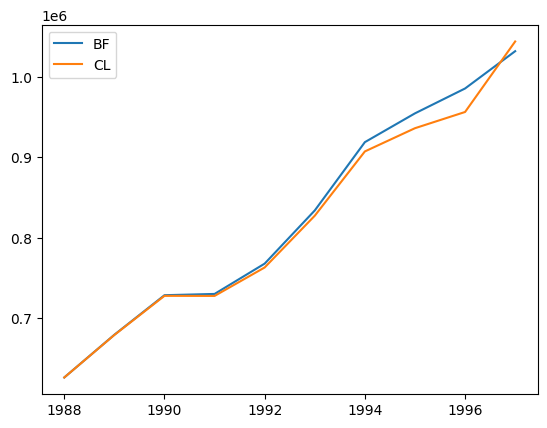

In [244]:
plt.plot(
    bf_model.ultimate_.to_frame(origin_as_datetime=True).index.year,
    bf_model.ultimate_.to_frame(origin_as_datetime=True),
    label="BF",
)

cl_model = cl.Chainladder().fit(comauto["CumPaidLoss"])
plt.plot(
    cl_model.ultimate_.to_frame(origin_as_datetime=True).index.year,
    cl_model.ultimate_.to_frame(origin_as_datetime=True),
    label="CL",
)

plt.legend(loc="upper left")

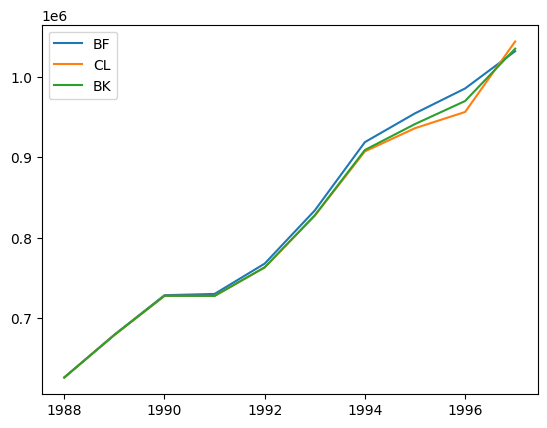

In [245]:
bk_model = cl.Benktander(apriori=0.75, n_iters=2)
bk_model.fit(
    comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

plt.plot(
    bf_model.ultimate_.to_frame(origin_as_datetime=True).index.year,
    bf_model.ultimate_.to_frame(origin_as_datetime=True),
    label="BF",
)
plt.plot(
    cl_model.ultimate_.to_frame(origin_as_datetime=True).index.year,
    cl_model.ultimate_.to_frame(origin_as_datetime=True),
    label="CL",
)
plt.plot(
    bk_model.ultimate_.to_frame(origin_as_datetime=True).index.year,
    bk_model.ultimate_.to_frame(origin_as_datetime=True),
    label="BK",
)
plt.legend(loc="upper left")

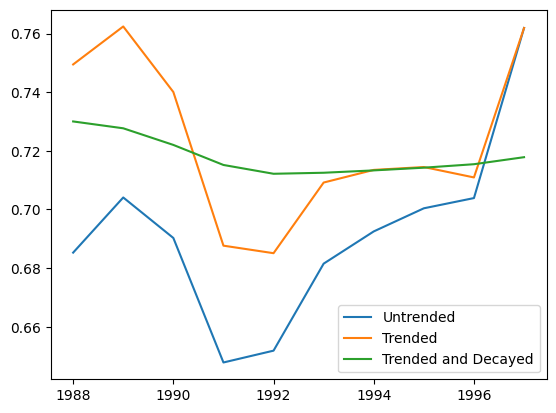

In [246]:
cc_model = cl.CapeCod(decay=0, trend=0).fit(
    comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

trended_cc_model = cl.CapeCod(decay=0, trend=0.01).fit(
    X=comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

trended_decayed_cc_model = cl.CapeCod(decay=0.75, trend=0.01).fit(
    X=comauto["CumPaidLoss"], sample_weight=comauto["EarnedPremNet"].latest_diagonal
)

plt.plot(
    cc_model.apriori_.to_frame(origin_as_datetime=True).index.year,
    cc_model.apriori_.to_frame(origin_as_datetime=True),
    label="Untrended",
)
plt.plot(
    trended_cc_model.apriori_.to_frame(origin_as_datetime=True).index.year,
    trended_cc_model.apriori_.to_frame(origin_as_datetime=True),
    label="Trended",
)
plt.plot(
    trended_decayed_cc_model.apriori_.to_frame(origin_as_datetime=True).index.year,
    trended_decayed_cc_model.apriori_.to_frame(origin_as_datetime=True),
    label="Trended and Decayed",
)
plt.legend(loc="lower right")

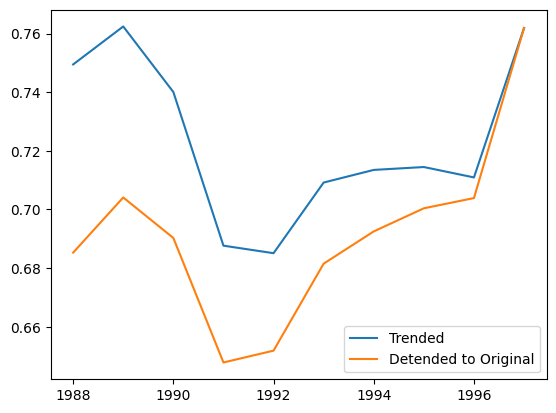

In [247]:
plt.plot(
    trended_cc_model.apriori_.to_frame(origin_as_datetime=True).index.year,
    trended_cc_model.apriori_.to_frame(origin_as_datetime=True),
    label="Trended",
)
plt.plot(
    trended_cc_model.detrended_apriori_.to_frame(origin_as_datetime=True).index.year,
    trended_cc_model.detrended_apriori_.to_frame(origin_as_datetime=True),
    label="Detended to Original",
)
plt.legend(loc="lower right")

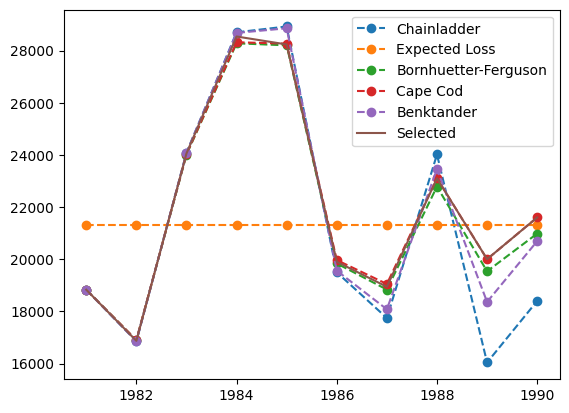

In [248]:
raa = cl.load_sample("raa")
cl_mod = cl.Chainladder()
el_mod = cl.ExpectedLoss(apriori=1)
bf_mod = cl.BornhuetterFerguson(apriori=1)
cc_mod = cl.CapeCod(decay=1, trend=0)
bk_mod = cl.Benktander(apriori=1, n_iters=2)

estimators = [
    ("cl", cl_mod),
    ("el", el_mod),
    ("bf", bf_mod),
    ("cc", cc_mod),
    ("bk", bk_mod),
]

sample_weight = cl_mod.fit(raa).ultimate_ * 0 + (
    float(cl_mod.fit(raa).ultimate_.values.sum()) / 10
)

model_weights = np.array(
    [[0.6, 0, 0.2, 0.2, 0]] * 4 + [[0, 0, 0.5, 0.5, 0]] * 3 + [[0, 0, 0, 1, 0]] * 3
)

vot_mod = cl.VotingChainladder(estimators=estimators, weights=model_weights).fit(
    raa, sample_weight=sample_weight
)

plt.plot(
    cl_mod.fit(raa).ultimate_.to_frame(origin_as_datetime=True).index.year,
    cl_mod.fit(raa).ultimate_.to_frame(origin_as_datetime=True),
    label="Chainladder",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    el_mod.fit(raa, sample_weight=sample_weight)
    .ultimate_.to_frame(origin_as_datetime=True)
    .index.year,
    el_mod.fit(raa, sample_weight=sample_weight).ultimate_.to_frame(
        origin_as_datetime=True
    ),
    label="Expected Loss",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    bf_mod.fit(raa, sample_weight=sample_weight)
    .ultimate_.to_frame(origin_as_datetime=True)
    .index.year,
    bf_mod.fit(raa, sample_weight=sample_weight).ultimate_.to_frame(
        origin_as_datetime=True
    ),
    label="Bornhuetter-Ferguson",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    cc_mod.fit(raa, sample_weight=sample_weight)
    .ultimate_.to_frame(origin_as_datetime=True)
    .index.year,
    cc_mod.fit(raa, sample_weight=sample_weight).ultimate_.to_frame(
        origin_as_datetime=True
    ),
    label="Cape Cod",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    bk_mod.fit(raa, sample_weight=sample_weight)
    .ultimate_.to_frame(origin_as_datetime=True)
    .index.year,
    bk_mod.fit(raa, sample_weight=sample_weight).ultimate_.to_frame(
        origin_as_datetime=True
    ),
    label="Benktander",
    linestyle="dashed",
    marker="o",
)
plt.plot(
    vot_mod.ultimate_.to_frame(origin_as_datetime=True).index.year,
    vot_mod.ultimate_.to_frame(origin_as_datetime=True),
    label="Selected",
)
plt.legend(loc="best")

In [249]:
vot_mod.weights

array([[0.6, 0. , 0.2, 0.2, 0. ],
       [0.6, 0. , 0.2, 0.2, 0. ],
       [0.6, 0. , 0.2, 0.2, 0. ],
       [0.6, 0. , 0.2, 0.2, 0. ],
       [0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. , 0. ]])

In [250]:
clrd = (
    cl.load_sample("clrd")
    .groupby("LOB")
    .sum()
    .loc["wkcomp", ["CumPaidLoss", "EarnedPremNet"]]
)
triang_stos_act['Pagados'].origin

PeriodIndex(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
             '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
             '2016', '2017', '2018', '2019'],
            dtype='period[Y-DEC]', name='origin')

In [251]:
triang_stos_act['Pagados'].incr_to_cum()

,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240
2000,"6,983,616,659","13,263,581,283","14,446,688,469","15,632,425,608","16,626,318,462","17,365,843,293","17,864,055,846","18,390,626,905","18,899,410,396","19,223,557,621","19,526,762,059","19,693,569,103","19,819,981,374","20,054,399,587","20,181,924,495","20,650,402,303","20,734,072,823","20,828,546,939","20,867,050,887","20,915,119,135"
2001,"7,379,571,372","10,786,740,647","12,266,498,380","13,190,740,694","13,934,682,644","14,564,649,830","14,956,364,964","15,459,856,927","15,848,898,834","16,166,995,141","16,474,644,084","16,731,908,789","16,911,496,338","17,166,035,707","17,253,538,112","17,322,548,055","17,395,462,198","17,431,631,906","17,457,343,680",
2002,"4,303,383,495","8,330,650,298","9,581,396,639","10,412,202,040","11,052,140,739","11,579,241,575","12,101,464,731","12,432,226,599","12,842,160,067","13,083,422,135","13,276,284,854","13,540,941,587","13,671,468,156","13,774,460,736","13,855,132,633","13,988,748,639","14,082,088,894","14,177,259,991",,
2003,"5,107,168,885","9,842,320,776","11,464,632,760","12,498,917,384","13,124,228,000","13,769,375,019","14,372,023,837","14,884,594,205","15,296,175,104","15,663,262,596","16,017,187,843","16,340,307,451","16,552,486,432","16,736,492,672","16,951,641,471","17,052,967,522","17,123,235,146",,,
2004,"6,626,404,193","12,432,085,776","14,353,048,797","15,360,188,528","16,250,408,859","17,069,331,186","17,783,367,954","18,309,157,713","18,738,307,926","19,104,579,112","19,521,665,609","19,833,443,690","20,098,380,641","20,313,829,830","20,502,027,788","20,590,481,586",,,,
2005,"7,719,999,021","14,924,743,824","16,902,195,496","18,248,969,735","19,401,970,285","20,410,797,941","21,235,891,187","21,883,407,450","22,513,428,817","23,069,488,644","23,487,822,904","23,955,030,727","24,395,815,562","24,641,190,850","24,771,375,681",,,,,
2006,"9,314,907,864","17,062,687,672","19,728,117,554","21,341,104,445","22,845,337,219","24,257,198,238","25,305,643,428","26,181,258,714","27,151,530,778","27,893,864,684","28,497,604,692","28,958,830,625","29,337,567,099","29,549,111,909",,,,,,
2007,"10,516,216,689","19,894,863,214","22,973,532,974","25,038,343,715","26,642,677,274","28,032,779,811","29,295,999,666","30,424,999,279","31,706,540,995","32,630,125,644","33,485,320,919","34,059,883,188","34,357,580,894",,,,,,,
2008,"12,029,568,137","22,174,889,429","25,297,081,370","27,438,641,215","29,359,992,355","30,776,440,283","32,240,376,446","33,551,982,831","34,834,475,675","35,947,488,050","36,686,235,390","37,048,430,718",,,,,,,,
2009,"12,703,697,559","22,583,189,260","25,761,760,982","27,987,909,777","29,630,368,535","31,282,417,232","32,730,027,728","34,340,655,247","35,615,436,661","36,480,147,397","37,028,468,628",,,,,,,,,


In [252]:
mack = cl.MackChainladder().fit(triang_stos_act['Pagados'].incr_to_cum())
clrd = triang_stos_act['Pagados'].incr_to_cum()
clrd_first_lags = clrd[clrd.development <= 24][clrd.origin < "2023"]
y = clrd_first_lags.to_frame(origin_as_datetime=True).values[:, 1]
x = clrd_first_lags.to_frame(origin_as_datetime=True).values[:, 0]

model = sm.WLS(y, x, weights=(1 / x) ** 2)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                     nan
Model:                            WLS   Adj. R-squared (uncentered):                nan
Method:                 Least Squares   F-statistic:                                nan
Date:                Sun, 21 Sep 2025   Prob (F-statistic):                         nan
Time:                        19:44:01   Log-Likelihood:                             nan
No. Observations:                  20   AIC:                                        nan
Df Residuals:                      19   BIC:                                        nan
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1                nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 $\frac{\sigma}{\sqrt{N}}$.

In [253]:
mack.parameter_risk_ + mack.process_risk_


,12,24,36,48,60,72,84,96,108,120,...,144,156,168,180,192,204,216,228,240,9999
2000,,,,,,,,,,,...,,,,,,,,,,
2001,,,,,,,,,,,...,,,,,,,,,"28,596,347","28,596,347"
2002,,,,,,,,,,,...,,,,,,,,"6,971,387","25,576,577","25,576,577"
2003,,,,,,,,,,,...,,,,,,,"60,389,531","61,017,075","67,650,480","67,650,480"
2004,,,,,,,,,,,...,,,,,,"34,551,153","77,058,736","77,728,422","84,767,384","84,767,384"
2005,,,,,,,,,,,...,,,,,"270,953,291","275,065,874","287,446,083","288,126,935","291,560,891","291,560,891"
2006,,,,,,,,,,,...,,,,"105,545,731","324,925,783","329,509,681","343,108,368","343,902,255","347,785,507","347,785,507"
2007,,,,,,,,,,,...,,,"102,911,651","156,860,413","377,851,895","382,928,492","397,844,708","398,751,974","403,112,603","403,112,603"
2008,,,,,,,,,,,...,,"155,388,265","191,214,016","229,726,829","432,486,064","437,792,757","452,963,654","453,965,752","458,527,445","458,527,445"
2009,,,,,,,,,,,...,"175,303,591","236,861,793","263,547,491","294,224,275","474,302,594","479,595,291","494,190,130","495,249,056","499,752,799","499,752,799"


In [254]:
mack.parameter_risk_**2 + mack.process_risk_**2 - mack.mack_std_err_**2

,12,24,36,48,60,72,84,96,108,120,...,144,156,168,180,192,204,216,228,240,9999
2000,,,,,,,,,,,...,,,,,,,,,,
2001,,,,,,,,,,,...,,,,,,,,,,
2002,,,,,,,,,,,...,,,,,,,,-0.00,0.06,0.06
2003,,,,,,,,,,,...,,,,,,,0.25,0.25,,
2004,,,,,,,,,,,...,,,,,,,,,-0.50,-0.50
2005,,,,,,,,,,,...,,,,,,,8.00,8.00,-8.00,-8.00
2006,,,,,,,,,,,...,,,,,,,,,,
2007,,,,,,,,,,,...,,,,,-16.00,-16.00,16.00,,,
2008,,,,,,,,,,,...,,-2.00,,,,16.00,-16.00,-16.00,-16.00,-16.00
2009,,,,,,,,,,,...,,,,,-16.00,16.00,,-16.00,,


In [255]:
mack.total_process_risk_**2 - (mack.process_risk_**2).sum(axis="origin")

,12,24,36,48,60,72,84,96,108,120,...,144,156,168,180,192,204,216,228,240,9999
2000,,,,"-1,024",,,,,"-2,048",,...,,,"-2,048",,"4,096","4,096","-4,096",,"4,096","4,096"


In [256]:
(mack.parameter_risk_**2 + mack.process_risk_**2).sum(axis=2).sum(axis=3) - (mack.mack_std_err_**2).sum(axis=2).sum(axis=3)

np.float64(0.0)

In [257]:
mack.summary_

,Latest,IBNR,Ultimate,Mack Std Err
2000,"20,915,119,135",,"20,915,119,135",
2001,"17,457,343,680","40,213,825","17,497,557,505","20,240,748"
2002,"14,177,259,991","56,507,861","14,233,767,852","18,188,157"
2003,"17,123,235,146","142,603,015","17,265,838,162","49,078,590"
2004,"20,590,481,586","267,803,199","20,858,284,785","61,153,958"
2005,"24,771,375,681","565,606,258","25,336,981,939","214,703,627"
2006,"29,549,111,909","897,105,952","30,446,217,862","253,806,074"
2007,"34,357,580,894","1,407,268,968","35,764,849,862","292,196,864"
2008,"37,048,430,718","1,969,915,370","39,018,346,087","332,284,122"
2009,"37,028,468,628","2,569,681,255","39,598,149,884","363,835,247"


(0.0, 75000000000.0)

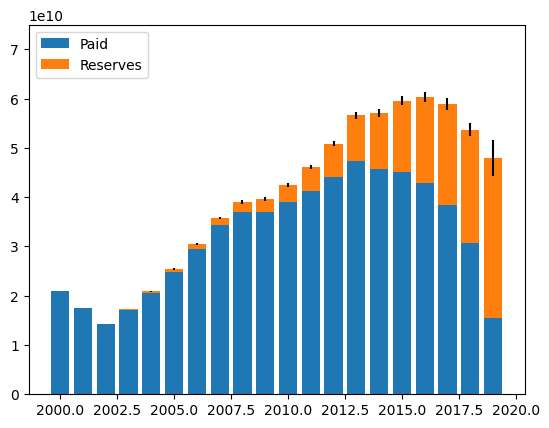

In [280]:
plt.bar(
    mack.summary_.to_frame(origin_as_datetime=True).index.year,
    mack.summary_.to_frame(origin_as_datetime=True)["Latest"],
    label="Paid",
)
plt.bar(
    mack.summary_.to_frame(origin_as_datetime=True).index.year,
    mack.summary_.to_frame(origin_as_datetime=True)["IBNR"],
    bottom=mack.summary_.to_frame(origin_as_datetime=True)["Latest"],
    yerr=mack.summary_.to_frame(origin_as_datetime=True)["Mack Std Err"],
    label="Reserves",
)
plt.legend(loc="upper left")
plt.ylim(0, 75000000000)

(array([  2.,   0.,   1.,   2.,   2.,   4.,   8.,   7.,  22.,  37.,  46.,
         67., 104., 151., 213., 254., 345., 409., 449., 504., 611., 643.,
        678., 676., 717., 662., 620., 554., 453., 424., 327., 316., 173.,
        160., 126.,  77.,  63.,  40.,  18.,  16.,   5.,   6.,   5.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.]),
 array([1.26709623e+11, 1.27740335e+11, 1.28771046e+11, 1.29801758e+11,
        1.30832469e+11, 1.31863181e+11, 1.32893892e+11, 1.33924604e+11,
        1.34955315e+11, 1.35986027e+11, 1.37016738e+11, 1.38047450e+11,
        1.39078161e+11, 1.40108873e+11, 1.41139584e+11, 1.42170296e+11,
        1.43201007e+11, 1.44231719e+11, 1.45262430e+11, 1.46293142e+11,
        1.47323853e+11, 1.48354565e+11, 1.49385276e+11, 1.50415988e+11,
        1.51446699e+11, 1.52477411e+11, 1.53508122e+11, 1.54538834e+11,
        1.55569545e+11, 1.56600257e+11, 1.57630968e+11, 1.58661680e+11,
        1.59692391e+11, 1.60723103e+11, 1.61753815e+11, 1.62784526e+11,
        1.

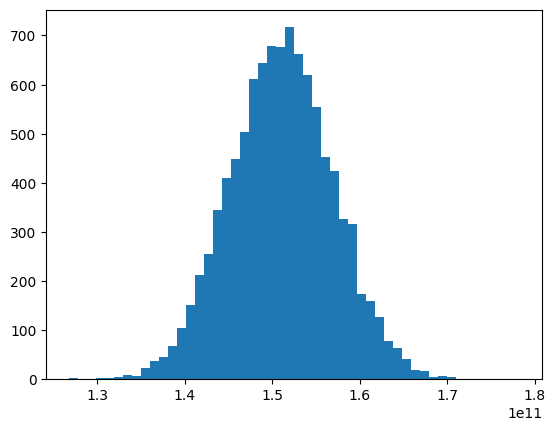

In [259]:
ibnr_mean = mack.ibnr_.sum()
ibnr_sd = mack.total_mack_std_err_.values[0, 0]
n_trials = 10000

np.random.seed(23)
dist = np.random.normal(ibnr_mean, ibnr_sd, size=n_trials)

plt.hist(dist, bins=50)

In [260]:
samples = (
    cl.BootstrapODPSample(n_sims=10000).fit(clrd).resampled_triangles_
)

In [261]:
ibnr_cl = cl.Chainladder().fit(clrd).ibnr_.sum()
ibnr_bootstrap = cl.Chainladder().fit(samples).ibnr_.sum("origin").mean()

print(
    "Chainladder's IBNR estimate:",
    ibnr_cl,
)
print(
    "BootstrapODPSample's mean IBNR estimate:",
    ibnr_bootstrap,
)
print("Difference $:", ibnr_cl - ibnr_bootstrap)
print("Difference %:", abs(ibnr_cl - ibnr_bootstrap) / ibnr_cl)

Chainladder's IBNR estimate: 151191268459.5416
BootstrapODPSample's mean IBNR estimate: 151166418168.35046
Difference $: 24850291.19113159
Difference %: 0.0001643632694157961


In [262]:
pipe = cl.Pipeline(
    steps=[("dev", cl.Development(average="simple")), ("tail", cl.TailConstant(1.05))]
)

pipe.fit(samples)
pipe.named_steps.dev.ldf_.iloc[0]

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132,132-144,144-156,156-168,168-180,180-192,192-204,204-216,216-228,228-240
(All),1.8104,1.1458,1.0875,1.0698,1.0574,1.0436,1.0434,1.0343,1.0287,1.0186,1.0183,1.0123,1.0133,1.0039,1.0111,1.0060,1.0043,1.0028,1.0012


In [263]:
pipe

,steps,"[('dev', ...), ('tail', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_periods,-1
,average,'simple'
,sigma_interpolation,'log-linear'
,drop,None
,drop_high,None
,drop_low,None
,preserve,1


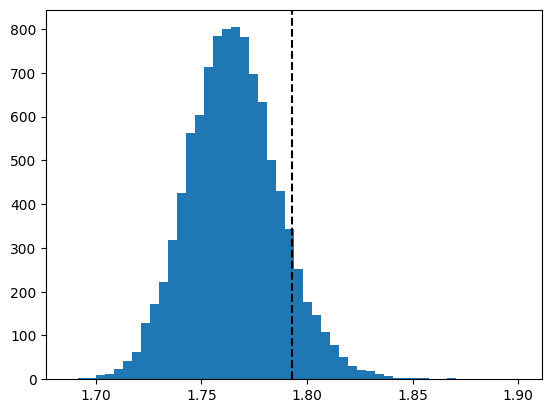

In [264]:
resampled_ldf = pipe.named_steps.dev.ldf_
plt.hist(pipe.named_steps.dev.ldf_.values[:, 0, 0, 0], bins=50)

orig_dev = cl.Development(average="simple").fit(clrd)
plt.axvline(orig_dev.ldf_.values[0, 0, 0, 0], color="black", linestyle="dashed")

In [265]:
bootstrap_vs_mack = resampled_ldf.std("index").to_frame(origin_as_datetime=False).T
bootstrap_vs_mack.rename(columns={"(All)": "Std_Bootstrap"}, inplace=True)
bootstrap_vs_mack = bootstrap_vs_mack.merge(
    orig_dev.std_err_.to_frame(origin_as_datetime=False).T,
    left_index=True,
    right_index=True,
)
bootstrap_vs_mack.rename(columns={"(All)": "Std_Mack"}, inplace=True)

bootstrap_vs_mack

,Std_Bootstrap,Std_Mack
12-24,0.021724,0.032470
24-36,0.005785,0.004464
36-48,0.004280,0.002537
48-60,0.003709,0.002585
60-72,0.003439,0.002236
72-84,0.003143,0.002527
84-96,0.002938,0.001958
96-108,0.002815,0.001867
108-120,0.002562,0.001550
120-132,0.002436,0.001175


([<matplotlib.axis.XTick at 0x1d608988f50>,
 [Text(0, 0, '12-24'),
  Text(1, 0, '24-36'),
  Text(2, 0, '36-48'),
  Text(3, 0, '48-60'),
  Text(4, 0, '60-72'),
  Text(5, 0, '72-84'),
  Text(6, 0, '84-96'),
  Text(7, 0, '96-108'),
  Text(8, 0, '108-120'),
  Text(9, 0, '120-132'),
  Text(10, 0, '132-144'),
  Text(11, 0, '144-156'),
  Text(12, 0, '156-168'),
  Text(13, 0, '168-180'),
  Text(14, 0, '180-192'),
  Text(15, 0, '192-204'),
  Text(16, 0, '204-216'),
  Text(17, 0, '216-228'),
  Text(18, 0, '228-240')])

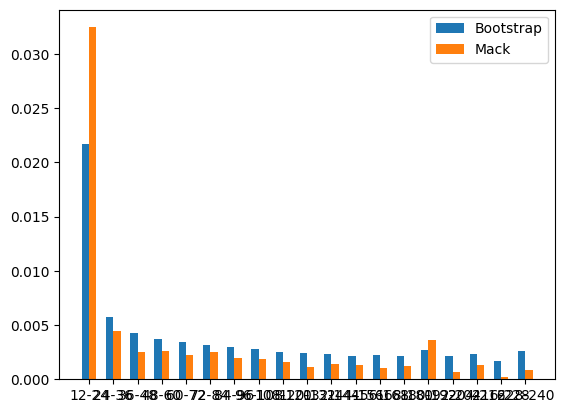

In [266]:
width = 0.3
ages = np.arange(len(bootstrap_vs_mack))

plt.bar(
    ages - width / 2,
    bootstrap_vs_mack["Std_Bootstrap"],
    width=width,
    label="Bootstrap",
)
plt.bar(ages + width / 2, bootstrap_vs_mack["Std_Mack"], width=width, label="Mack")
plt.legend(loc="upper right")
plt.xticks(ages, bootstrap_vs_mack.index)

In [267]:
aaaaa = cl.Chainladder().fit(samples)

In [268]:
aaaaa.ibnr_.sum().to_frame(origin_as_datetime=True)

,2261
2000-01-01,NaN
2001-01-01,4.065784e+11
2002-01-01,5.702480e+11
2003-01-01,1.428665e+12
2004-01-01,2.680213e+12
2005-01-01,5.652149e+12
2006-01-01,8.974754e+12
2007-01-01,1.407300e+13
2008-01-01,1.969223e+13
2009-01-01,2.568458e+13


In [269]:
clrd.latest_diagonal

,2019
2000,"20,915,119,135"
2001,"17,457,343,680"
2002,"14,177,259,991"
2003,"17,123,235,146"
2004,"20,590,481,586"
2005,"24,771,375,681"
2006,"29,549,111,909"
2007,"34,357,580,894"
2008,"37,048,430,718"
2009,"37,028,468,628"


In [270]:
clrd.latest_diagonal

,2019
2000,"20,915,119,135"
2001,"17,457,343,680"
2002,"14,177,259,991"
2003,"17,123,235,146"
2004,"20,590,481,586"
2005,"24,771,375,681"
2006,"29,549,111,909"
2007,"34,357,580,894"
2008,"37,048,430,718"
2009,"37,028,468,628"


In [271]:
aaaaa.ibnr_.mean()

,2261
2000,
2001,"40,657,843"
2002,"57,024,799"
2003,"142,866,485"
2004,"268,021,294"
2005,"565,214,916"
2006,"897,475,387"
2007,"1,407,300,261"
2008,"1,969,222,946"
2009,"2,568,458,335"


In [272]:
mack.summary_.to_frame(origin_as_datetime=True)["Mack Std Err"]

2000-01-01             NaN
2001-01-01    2.024075e+07
2002-01-01    1.818816e+07
2003-01-01    4.907859e+07
2004-01-01    6.115396e+07
2005-01-01    2.147036e+08
2006-01-01    2.538061e+08
2007-01-01    2.921969e+08
2008-01-01    3.322841e+08
2009-01-01    3.638352e+08
2010-01-01    4.043844e+08
2011-01-01    4.739944e+08
2012-01-01    5.744946e+08
2013-01-01    6.910567e+08
2014-01-01    8.117535e+08
2015-01-01    9.306534e+08
2016-01-01    1.067539e+09
2017-01-01    1.174949e+09
2018-01-01    1.336538e+09
2019-01-01    3.724887e+09
Freq: YS-JAN, Name: Mack Std Err, dtype: float64

(0.0, 75000000000.0)

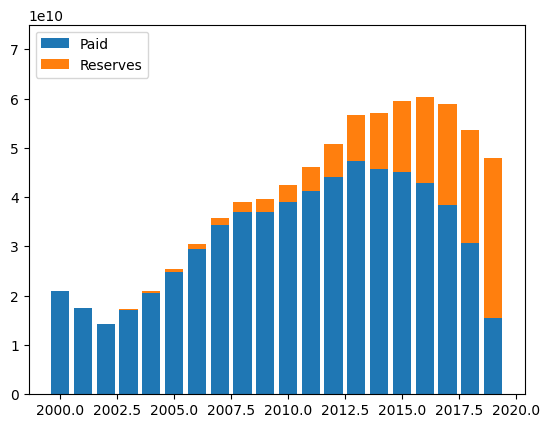

In [278]:
plt.bar(
    clrd.latest_diagonal.to_frame(origin_as_datetime=True).index.year,
    clrd.latest_diagonal.to_frame(origin_as_datetime=True)['2019'],
    label="Paid",
)

plt.bar(
    aaaaa.ibnr_.mean().to_frame(origin_as_datetime=True).index.year,
    aaaaa.ibnr_.mean().to_frame(origin_as_datetime=True)['2261'],
    bottom=clrd.latest_diagonal.to_frame(origin_as_datetime=True)['2019'],
    label="Reserves",
)
plt.legend(loc="upper left")
plt.ylim(0, 75000000000)

In [ ]:
ibnr = cl.Chainladder().fit(samples).ibnr_.sum("origin")

ibnr_std = ibnr.std()
print("Standard deviation of reserve estimate: " + f"{round(ibnr_std,0):,}")
ibnr_99 = ibnr.quantile(q=0.99)
print("99th percentile of reserve estimate: " + f"{round(ibnr_99,0):,}")

Standard deviation of reserve estimate: 90,520,708,713.0
99th percentile of reserve estimate: 854,029,331,943.0


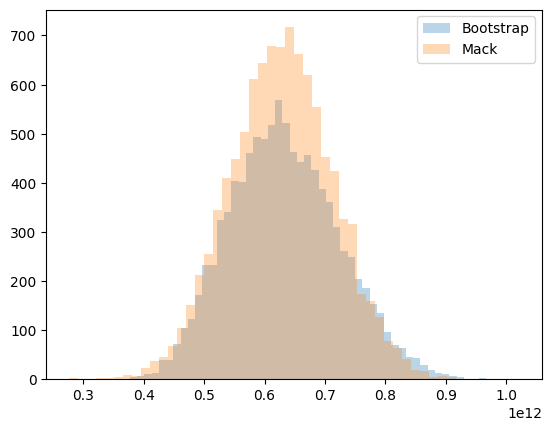

In [ ]:
plt.hist(ibnr.to_frame(origin_as_datetime=True), bins=50, label="Bootstrap", alpha=0.3)
plt.hist(dist, bins=50, label="Mack", alpha=0.3)
plt.legend(loc="upper right")